# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

Text(0, 0.5, 'm')

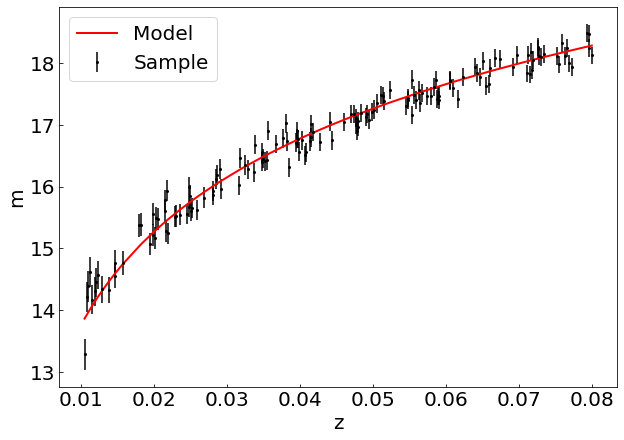

In [129]:
# TODO: generate and plot data with error bars
sample = make_synthetic_sample(N=150)

plt.figure(figsize=(10,7))
plt.errorbar(sample.z, sample.m, sample.sigma_m, linestyle="", marker="o", ms=2, color="k", label="Sample")
plt.plot(sample.z, mag_model(sample.z, H0=73.0, M=-19.3), lw=2, color="r", label="Model")
plt.tick_params(axis='both', direction="in", labelsize=20)
plt.legend(loc="upper left", fontsize=20)
plt.xlabel("z", fontsize=20)
plt.ylabel("m", fontsize=20)

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [130]:
# TODO: define chi2 function
def chi2(theta, y, sigma):
    return np.sum(((theta - y)/sigma)**2)

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

Text(0, 0.5, 'chi2')

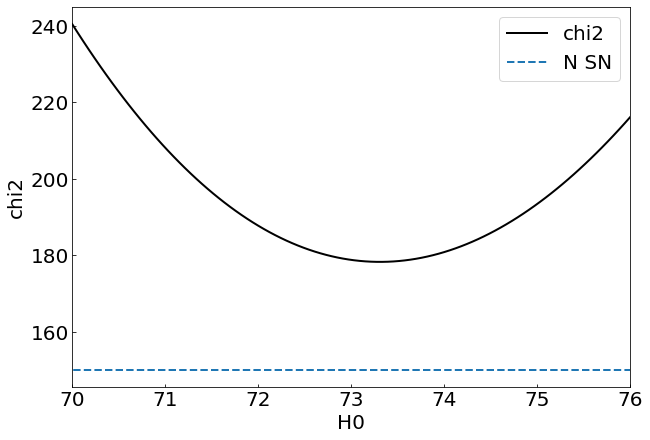

In [131]:
# TODO: use numpy or scipy to minimize chi2
# best_fit of H0 = ...
H_array = np.linspace(70, 76, 100)
y_array = np.array([mag_model(sample.z, H0=H_array[i], M=-19.3) for i in range(len(H_array))])
chi2_array = np.array([chi2(sample.m, y_array[i], sample.sigma_m) for i in range(len(y_array))])

plt.figure(figsize=(10,7))
plt.plot(H_array, chi2_array, lw=2, color="k", label="chi2")
plt.hlines(len(sample.z), 50, 100, ls="--", lw=2, label="N SN")
plt.tick_params(axis='both', direction="in", labelsize=20)
plt.legend(loc="upper right", fontsize=20)
plt.xlim(70, 76)
plt.xlabel("H0", fontsize=20)
plt.ylabel("chi2", fontsize=20)

In [132]:
# TODO: say something about goodness of fit
model_best = y_array[np.argmin(chi2_array)]

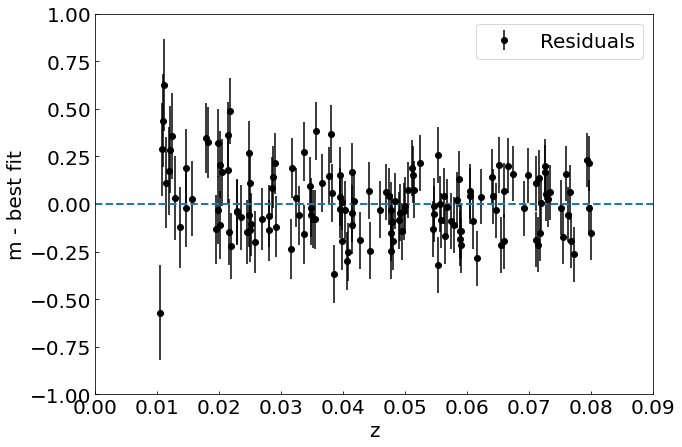

In [133]:
# TODO: plot residuals, always!
plt.figure(figsize=(10,7))
plt.errorbar(sample.z, sample.m - model_best, sample.sigma_m, linestyle="", marker="o", color="k", label="Residuals")
plt.hlines(0, 0, 1, ls="--", lw=2)
plt.tick_params(axis='both', direction="in", labelsize=20)
plt.legend(loc="upper right", fontsize=20)
plt.xlim(0, 0.09)
plt.ylim(-1, 1)
plt.xlabel("z", fontsize=20)
plt.ylabel("m - best fit", fontsize=20)
plt.show()

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

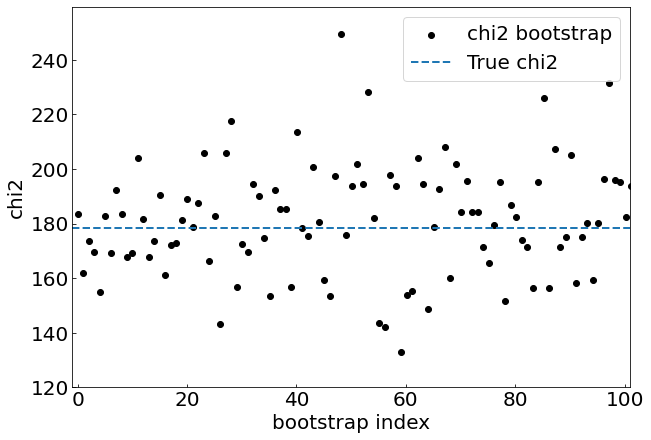

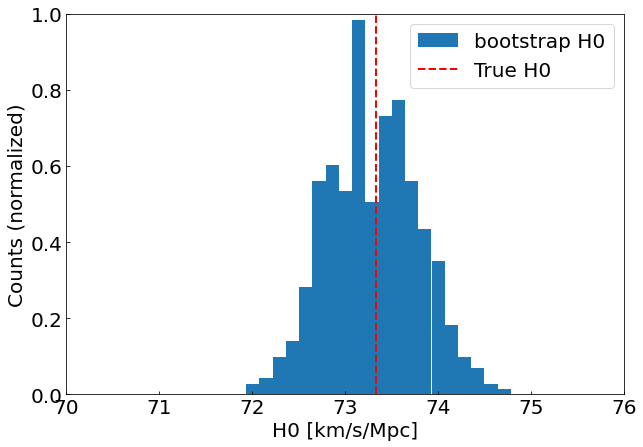

In [139]:
# TODO: implement bootstrap loop, any ideas how to do this?

# The concept is to resample the data with replacement, fit each resampled dataset, and collect the best-fit parameters to estimate uncertainties.
def bootstrap_resample(sample=sample):
    sample_size = len(sample.z)
    val_max = np.random.randint(low=100, high=150)
    n_vals = np.arange(0, val_max)
    rng_indexes = np.random.choice(n_vals, sample_size)
    return rng_indexes

idx_to_test = np.linspace(0, 500, 500)
chi2_best = []
H0_best = []
for i in range(len(idx_to_test)):
    idx_to_sample = bootstrap_resample()
    z_samples = sample.z[idx_to_sample]
    m_samples = sample.m[idx_to_sample]
    sm_samples = sample.sigma_m[idx_to_sample]

    y_array = np.array([mag_model(z_samples, H0=H_array[i], M=-19.3) for i in range(len(H_array))])
    chi2_array_sample = np.array([chi2(m_samples, y_array[i], sm_samples) for i in range(len(y_array))])
    chi2_best.append(chi2_array_sample[np.argmin(chi2_array_sample)])
    H0_best.append(H_array[np.argmin(chi2_array_sample)])
chi2_best = np.array(chi2_best)
H0_best = np.array(H0_best)

plt.figure(figsize=(10,7))
plt.scatter(idx_to_test, chi2_best, marker="o", color="k", label="chi2 bootstrap")
plt.hlines(chi2_array[np.argmin(chi2_array)], -1, 101, ls="--", lw=2, label="True chi2")
plt.tick_params(axis='both', direction="in", labelsize=20)
plt.legend(loc="upper right", fontsize=20)
plt.xlim(-1, 101)
plt.ylim(np.min(chi2_best)-10, np.max(chi2_best)+10)
plt.xlabel("bootstrap index", fontsize=20)
plt.ylabel("chi2", fontsize=20)
plt.show()

plt.figure(figsize=(10,7))
plt.hist(H0_best, bins=20, label="bootstrap H0", density=True)
plt.vlines(H_array[[np.argmin(chi2_array)]], 0, 500, lw=2, ls="--", color="r", label="True H0")
plt.tick_params(axis='both', direction="in", labelsize=20)
plt.legend(loc="upper right", fontsize=20)
plt.xlim(70, 76)
plt.ylim(0, 1)
plt.xlabel("H0 [km/s/Mpc]", fontsize=20)
plt.ylabel("Counts (normalized)", fontsize=20)
plt.show()

### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [ ]:
# TODO: let's calculate a p-value from the sampled probability

### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [ ]:
# TODO: implement grid posterior evaluation

### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [1]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [ ]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare